<a href="https://colab.research.google.com/github/Arindam75/graph_networks/blob/main/06_graph_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install torch_geometric

## Load Data

In [38]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

## Building the GAN

In [39]:
def accuracy(y_pred, y_true):
  return torch.sum(y_pred == y_true) / len(y_true)

class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()

    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out,heads=1)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
      super().__init__()
      self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
      self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

  def forward(self, x, edge_index):
      h = F.dropout(x, p=0.6, training=self.training)
      h = self.gat1(h, edge_index)
      h = F.elu(h)
      h = F.dropout(h, p=0.6, training=self.training)
      h = self.gat2(h, edge_index)
      return F.log_softmax(h, dim=1)

  def fit(self, data , epochs):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

    self.train()
    for epoch in range(epochs):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)

      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if epoch%20==0:
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [40]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)


In [41]:
# Train
gat.fit(data, epochs=100)


Epoch   0 | Train Loss: 1.968 | Train Acc: 15.71% | Val Loss: 1.96 | Val Acc: 16.00%
Epoch  20 | Train Loss: 0.187 | Train Acc: 97.86% | Val Loss: 1.01 | Val Acc: 69.00%
Epoch  40 | Train Loss: 0.175 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.60%
Epoch  60 | Train Loss: 0.160 | Train Acc: 98.57% | Val Loss: 0.87 | Val Acc: 75.00%
Epoch  80 | Train Loss: 0.170 | Train Acc: 99.29% | Val Loss: 0.91 | Val Acc: 73.40%


In [42]:
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 80.30%


## Tesing GAN on CiteSeer Dataset

In [43]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

Some basic analysis of the dataset

In [44]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
import numpy as np

<BarContainer object of 32 artists>

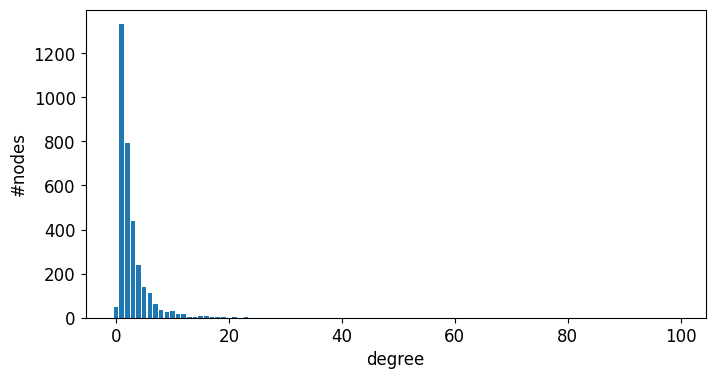

In [45]:
degrees = degree(dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.set_xlabel('degree')
ax.set_ylabel('#nodes')
ax.bar(numbers.keys(), numbers.values())

We have an obvious problem , there are some nodes which have 0 degree. Meaning they aren't connected to any node.

In [46]:
gat = GAT(dataset.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.798 | Train Acc: 18.33% | Val Loss: 1.82 | Val Acc: 12.20%
Epoch  20 | Train Loss: 0.185 | Train Acc: 97.50% | Val Loss: 1.20 | Val Acc: 57.00%
Epoch  40 | Train Loss: 0.123 | Train Acc: 99.17% | Val Loss: 1.13 | Val Acc: 63.40%
Epoch  60 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 1.29 | Val Acc: 57.60%
Epoch  80 | Train Loss: 0.105 | Train Acc: 100.00% | Val Loss: 1.19 | Val Acc: 58.80%


In [47]:
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 69.00%


To see the effect of degree on accuracy , we make a list of node-degree vs accuracy.

In [52]:
y_pred = gat(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []

#degrees from 1 to 5
for i in range(6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(y_pred.argmax(dim=1)[mask],data.y[mask]))
  sizes.append(len(mask))

#degrees greater than 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(y_pred.argmax(dim=1)[mask],
data.y[mask]))
sizes.append(len(mask))

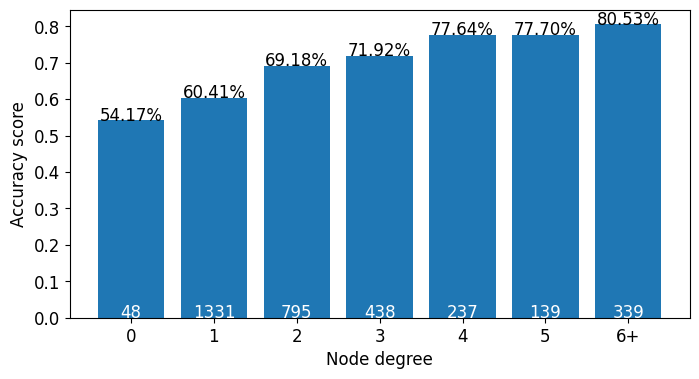

In [54]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
  plt.text(i, accuracies[i],
          f'{accuracies[i]*100:.2f}%',
          ha='center', color='black')
for i in range(0, 7):
  plt.text(i, accuracies[i]//2,
           sizes[i],
           ha='center',
           color='white')

This shows us that , the accuracy and the node degree are significantly correlated. Nodes with few neighbors are harder to classify correctly.
Furthermore, it even shows that, in general, the higher the node degree, the better the accuracy score. This is quite natural because a higher number of neighbors will provide more information to the GNN to make its predictions. ( from textbook "Graph Neural Networks Usng Python - Maxime Labonne" )